In [28]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *
from sklearn.model_selection import train_test_split
from funcions_net import *
from datasets_separats import *


In [29]:

df_orig, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

datasets = dataset_dif2(df_orig, dict,df_variables)

df_inicial = dataset_inicial(df_orig, dict)


df_psico = dataset_psicologia(df_orig, dict,df_variables)


df = drop_all_columns(df_psico, meta, df_variables, dict)


# Columnes que ja existeixen a df
columnes_comunes = df.columns.intersection(df_inicial.columns)

# Elimina les columnes duplicades de df_inicial
df_inicial_filtrat = df_inicial.drop(columns=columnes_comunes)

# Uneix columnes sense duplicats i alineant per fila
df = pd.concat([df.reset_index(drop=True), df_inicial_filtrat.reset_index(drop=True)], axis=1)



df["primer_mes"] = df_orig['temps_fins_reincidencia1a'].between(0, 60)




c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\datasets_separats.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  datasets[dataset_name][dict[i+1]] = df[dict[i+1]]
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\datasets_separats.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  datasets[dataset_name][dict[i+1]] = df[dict[i+1]]
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\datasets_separats.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

Creant dataset inicial
Creant dataset origen
(72, 15)
Creant dataset origen
(72, 37)
Delictes comesos
(72, 15)
Dataset final
(72, 15)
Dataset final
(72, 52)


In [30]:
df["primer_mes"].value_counts()


primer_mes
False    39
True     33
Name: count, dtype: int64

In [31]:
df.shape

(72, 189)

In [32]:
print("Mirem quants nans tenim a cada columna")
netejat,df = neteja_na_columns(df, llindar=0.6)

df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)


Mirem quants nans tenim a cada columna
Columnes netejades


In [33]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  175  columnes


In [34]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='primer_mes'), df['primer_mes'], test_size=0.2,random_state=20, stratify=df['primer_mes'])


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_train = pd.DataFrame(X_train, columns=df.drop(columns='primer_mes').columns)

In [36]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression  # o un altre model com RandomForestClassifier

# Defineix el model base
model = LogisticRegression(solver='liblinear')  # o el que prefereixis

# Defineix quantes característiques vols seleccionar
n_features_to_select = 100  # pots canviar aquest valor segons el teu cas

# Aplica RFE
selector = RFE(estimator=model, n_features_to_select=n_features_to_select)
selector = selector.fit(X_train, y_train)

# Obté les columnes seleccionades
selected_features = X_train.columns[selector.support_]


In [37]:
print("Columnes seleccionades:", len(selected_features.tolist()))

# Ens assegurem que X_train és un DataFrame i conté les columnes seleccionades
X_train_selected = pd.DataFrame(X_train[selected_features.tolist()], columns=selected_features.tolist())

# Per coherència, fem el mateix amb X_test
X_test_selected = pd.DataFrame(X_test[selected_features.tolist()], columns=selected_features.tolist())


Columnes seleccionades: 100


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Inicialitzem el model
rf = RandomForestClassifier(random_state=42)

# Definim la graella de paràmetres a explorar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10,15,20],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,scoring='f1', 
                           cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train_selected, y_train)

print("Millors paràmetres trobats:", grid_search.best_params_)
print("Millor score (accuracy CV):", grid_search.best_score_)



Fitting 5 folds for each of 15 candidates, totalling 75 fits
Millors paràmetres trobats: {'max_depth': 5, 'n_estimators': 200}
Millor score (accuracy CV): 0.6031746031746031


In [40]:
from sklearn.metrics import accuracy_score, classification_report

# Fem prediccions amb el millor model trobat
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)

# Avaluem el rendiment
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy sobre el test: {acc:.4f}")

# Informe complet de classificació
print("\nInforme de classificació:")
print(classification_report(y_test, y_pred))

## confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))


Accuracy sobre el test: 0.4667

Informe de classificació:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         8
        True       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.23      0.50      0.32        15
weighted avg       0.22      0.47      0.30        15



c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Accuracy sobre el test: 0.4667

Informe de classificació:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         8
        True       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.23      0.50      0.32        15
weighted avg       0.22      0.47      0.30        15



c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

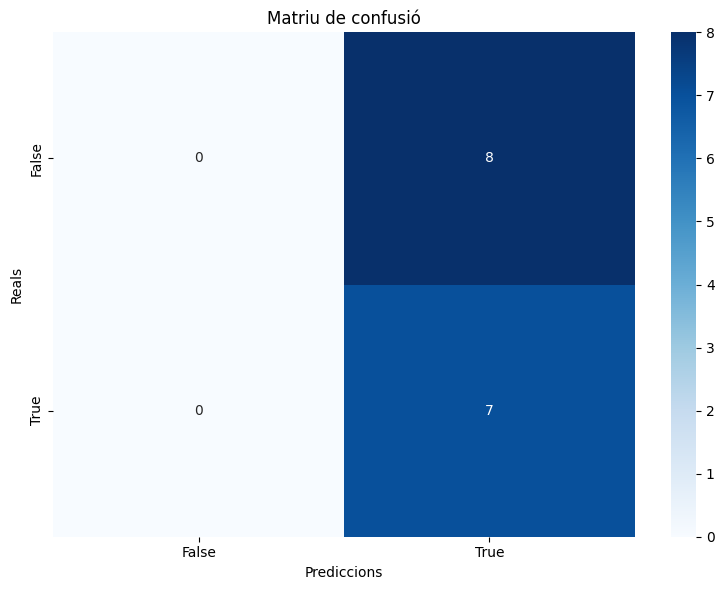

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fem prediccions amb el millor model trobat
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)

# Avaluació bàsica
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy sobre el test: {acc:.4f}")

# Informe detallat
print("\nInforme de classificació:")
print(classification_report(y_test, y_pred))

# Matriu de confusió
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Prediccions')
plt.ylabel('Reals')
plt.title('Matriu de confusió')
plt.tight_layout()
plt.show()
